# Exploración y preprocesamiento de los datos

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.pyplot as plt2
import os
from os import listdir
from os.path import isfile, join
from skimage import io
from PIL import Image 
import random

## <font color=red>1. </font>Cargar las imágenes y los datos tabulares

In [2]:
# Original size images directories
dir_train_images = "/kaggle/input/siimisic2020/train/"
train_images = [f for f in listdir(dir_train_images) if isfile(join(dir_train_images, f))]
dir_test_images = "/kaggle/input/siim-isic-2019/test/"
test_images = [f for f in listdir(dir_test_images) if isfile(join(dir_test_images, f))]

# CSV files
train_df = pd.read_csv('/kaggle/input/siimisic2020/train.csv')
test_df = pd.read_csv('/kaggle/input/siim-isic-2019/ISIC_2019_Training_Metadata.csv', delimiter=';')
gt = pd.read_csv('/kaggle/input/siim-isic-2019/ISIC_2019_Training_GroundTruth.csv')

In [3]:
# Add .jpg to image_name
def append_ext(filename):
    if filename[-4:] != ".jpg":
        return filename + ".jpg"
    else:
        return filename

train_df["image_name"] = train_df["image_name"].apply(append_ext)
test_df["image"] = test_df["image"].apply(append_ext)
gt["image"] = gt["image"].apply(append_ext)

In [4]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011.jpg,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719.jpg,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212.jpg,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279.jpg,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268.jpg,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
test_df.head()

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000.jpg,55.0,anterior torso,NaN,female
1,ISIC_0000001.jpg,30.0,anterior torso,NaN,female
2,ISIC_0000002.jpg,60.0,upper extremity,NaN,female
3,ISIC_0000003.jpg,30.0,upper extremity,NaN,male
4,ISIC_0000004.jpg,80.0,posterior torso,NaN,male


In [6]:
gt.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <font color=red>2. </font>Exploración de datos

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [8]:
patient_id_count = train_df['patient_id'].count()
patient_id_unique_count = train_df['patient_id'].value_counts().shape[0]
print("Total number of patient id:", patient_id_count, "| Total unique id:", patient_id_unique_count)

Total number of patient id: 33126 | Total unique id: 2056


#### Se observa que hay varias imagenes provenientes de cada paciente.

<AxesSubplot:>

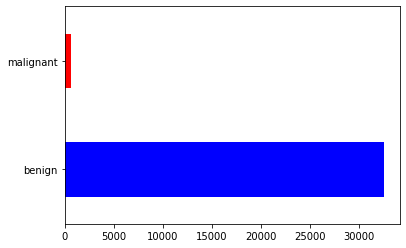

In [9]:
train_df.benign_malignant.value_counts().plot.barh(color=['b', 'r'])

In [10]:
train_df.benign_malignant.value_counts().rename_axis('Type').reset_index(name='Total samples')

,Type,Total samples
0,benign,32542
1,malignant,584


#### Al representar el número de muestras de cada tipo, observamos que hay más registros benignos que de malignos. Esto es normal ya que en el mundo real la frecuencia de tumores existe más tumores benignos que malignos. Por lo que produce un desequilibrio del conjunto de datos.

#### Se visualiza de qué parte del cuerpo provienen la mayoría de las imágenes del conjunto de entrenamiento:

<AxesSubplot:>

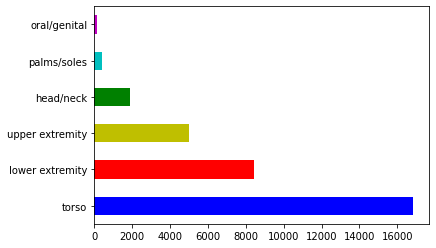

In [11]:
train_df.anatom_site_general_challenge.value_counts().plot.barh(color=['b', 'r', 'y', 'g', 'c', 'm'])

#### Se observa que hay un desequilibrio en las partes del cuerpo en el cual se han extraído las imágenes, siendo el más común el torso.

<AxesSubplot:>

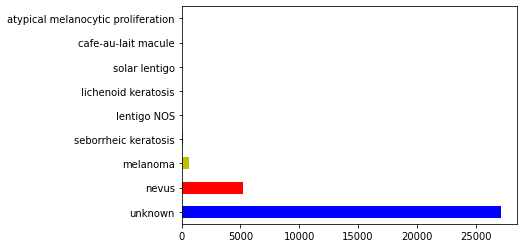

In [12]:
train_df.diagnosis.value_counts().plot.barh(color=['b', 'r', 'y', 'g', 'c', 'm'])

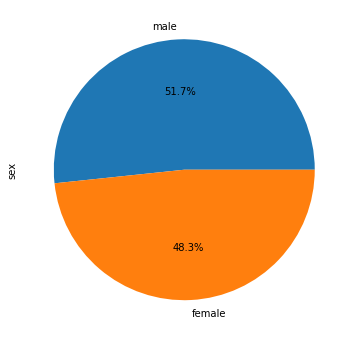

In [13]:
plot = train_df.sex.value_counts().plot.pie(subplots=True, figsize=(11, 6),autopct='%1.1f%%')

<AxesSubplot:>

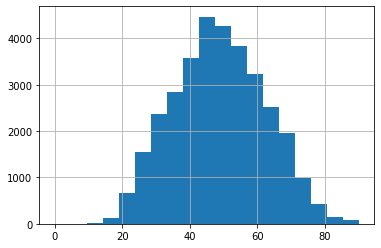

In [14]:
train_df.age_approx.hist(bins=len(train_df['age_approx'].unique()))

#### Como se observa, las personas de mediana edad tienen más probabilidades de contraer melanoma (y cáncer en general, como han demostrado los estudios).

## <font color=red>3. </font>Procesamiento de datos

#### A continuación, se extrae los datos faltantes del conjunto de entrenamiento y prueba.

In [15]:
# Returns number of missing values and percentage for each feature
def missing_values(df):
    missing_values = df.isnull().sum()
    percentage_missing_values = 100 * df.isnull().sum() / len(df)
    missing_values_table = pd.concat([missing_values, percentage_missing_values], axis=1)
    missing_values_table.columns = ['Missing values', '% of total missing values']
    missing_values_table = missing_values_table.sort_values(by=['Missing values'], ascending=False)
    return missing_values_table

In [16]:
# Delete useless columns
train_df = train_df.drop(columns=['diagnosis','benign_malignant'])
test_df = test_df.drop(columns=['lesion_id'])
missing_values(train_df), missing_values(test_df)

(                               Missing values  % of total missing values
 anatom_site_general_challenge             527                   1.590895
 age_approx                                 68                   0.205277
 sex                                        65                   0.196220
 image_name                                  0                   0.000000
 patient_id                                  0                   0.000000
 target                                      0                   0.000000,
                      Missing values  % of total missing values
 anatom_site_general            2631                  10.386483
 age_approx                      437                   1.725159
 sex                             384                   1.515929
 image                             0                   0.000000)

#### Se opta por eliminar los registros faltantes ya que son minúsculos.

In [17]:
train_df = train_df.dropna()
test_df = test_df.dropna()

#### Se procede a extraer, eliminar y unir las columnas con el fin de transformar el dataframe y obtener uno idéntico al de la competición de 2020.

In [18]:
# Select columns and join target column
test_df = test_df.join(gt['MEL'])
test_df = test_df.rename(columns={'image':'image_name', 'anatom_site_general':'anatom_site_general_challenge', 'MEL':'target'})
test_df = test_df[['image_name','sex','age_approx', 'anatom_site_general_challenge', 'target']]

test_df.head()

,image_name,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_0000000.jpg,female,55.0,anterior torso,0.0
1,ISIC_0000001.jpg,female,30.0,anterior torso,0.0
2,ISIC_0000002.jpg,female,60.0,upper extremity,1.0
3,ISIC_0000003.jpg,male,30.0,upper extremity,0.0
4,ISIC_0000004.jpg,male,80.0,posterior torso,1.0


In [19]:
train_df.target.value_counts().rename_axis('Type').reset_index(name='Total samples')

,Type,Total samples
0,0,31956
1,1,575


In [20]:
test_df.target.value_counts().rename_axis('Type').reset_index(name='Total samples')

,Type,Total samples
0,0.0,18134
1,1.0,4346


#### Se calcula la frecuencia de cáncer en cada conjunto de datos:

In [21]:
def compute_class_frequences(labels):
    # Total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies
    return positive_frequencies, negative_frequencies

labels_train = train_df["target"].astype(int).to_numpy()
positive_frequence_train, negative_frequence_train = compute_class_frequences(labels_train)

labels_test = test_df["target"].astype(int).to_numpy()
positive_frequence_test, negative_frequence_test = compute_class_frequences(labels_test)

print("Frequency of images with melanoma in training set -", positive_frequence_train)
print("Frequency of images benign in training set -", negative_frequence_train)
print("------------------------------------------------")
print("Frequency of images with melanoma in test set -", positive_frequence_test)
print("Frequency of images benign in test set -", negative_frequence_test)

Frequency of images with melanoma in training set - 0.017675448034182778
Frequency of images benign in training set - 0.9823245519658172
------------------------------------------------
Frequency of images with melanoma in test set - 0.1933274021352313
Frequency of images benign in test set - 0.8066725978647686


In [22]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (32531, 6)
Test shape: (22480, 5)


## <font color=red>4. </font> Redimensión de imágenes

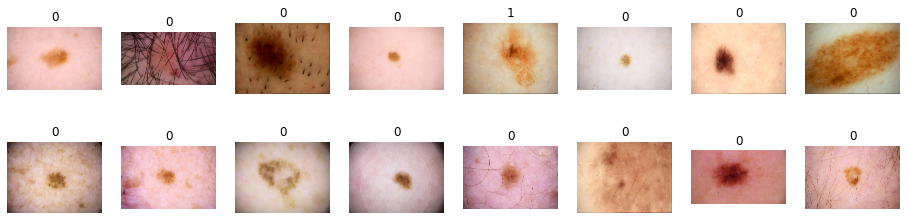

In [44]:
def show_images_jpg():
    row, column = 2, 8
    fig = plt.figure(figsize=(2*column, 2*row))
    for _r in range(row):
        for _c in range(column):
            plt.subplot(row, column, _r*column + _c +1)
            ran = random.randint(0, len(train_images)-1)
            name = train_df['image_name'].values[ran]
            img = io.imread(dir_train_images + name)
            plt.imshow(img)
            plt.axis(False)
            label = train_df['target'].values[ran]
            plt.title(label)
    plt.show()

show_images_jpg()

#### Observamos como se redimensionará las imágenes. Se muestra la siguiente imagen como ejemplo:

Width = 6000 | Height = 4000


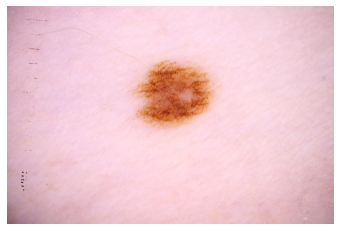

In [24]:
name = train_df['image_name'].values[5]
img = Image.open(dir_train_images + name)
width, height = img.size
print(f'Width = {width} | Height = {height}')
plt.imshow(img)
plt.axis(False)

plt.show()

Width = 224 | Height = 149


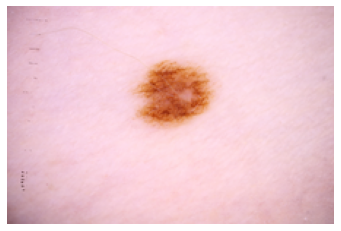

In [25]:
# Scale the image maintaining aspect ratio 
img.thumbnail((224, 224), Image.ANTIALIAS)
width, height = img.size
print(f'Width = {width} | Height = {height}')
plt.imshow(img)
plt.axis(False)

plt.show()

#### Se procede a redimensionar las imágenes.

In [26]:
def resize_images_jpg(dir_original_images, df, file, x, y):
    dir_images = '/kaggle/working/' + file + "/" 
    try:
        os.mkdir('/kaggle/working/' + file)
        print("Directory", file, "created") 
    except FileExistsError:
        print("Directory", file, "already exists")
        
    print("Resizing images...")
    total_images = len(df['image_name'])
    total_images_resized = 0
    
    for image in df['image_name'].values:
        img = Image.open(dir_original_images + image)
        img.thumbnail((x, y), Image.ANTIALIAS)
        img.save(dir_images + image)
        total_images_resized += 1
        percentage_resized = (total_images_resized / total_images) * 100
        # Every 1000 images saved, print progress
        if total_images_resized % 1000 == 0:
            print("Images resized & saved", percentage_resized, "%")
    print("Images resized")

    
def delete_images_jpg(file):
    try:
        os.system(f'rm -rf /kaggle/working/{file}')
        print(f'Directory {file} deleted')
    except:
        print("Could not delete directory")

In [27]:
delete_images_jpg("train_resized")
delete_images_jpg("test_resized")

Directory train_resized deleted
Directory test_resized deleted


In [28]:
print("Trying to resize train images...")
resize_images_jpg(dir_train_images, train_df, "train_resized", 224, 224)

Trying to resize train images...
Directory train_resized created
Resizing images...
Images resized & saved 3.07399096246657 %
Images resized & saved 6.14798192493314 %
Images resized & saved 9.221972887399712 %
Images resized & saved 12.29596384986628 %
Images resized & saved 15.36995481233285 %
Images resized & saved 18.443945774799424 %
Images resized & saved 21.51793673726599 %
Images resized & saved 24.59192769973256 %
Images resized & saved 27.665918662199136 %
Images resized & saved 30.7399096246657 %
Images resized & saved 33.813900587132274 %
Images resized & saved 36.88789154959885 %
Images resized & saved 39.961882512065415 %
Images resized & saved 43.03587347453198 %
Images resized & saved 46.109864436998556 %
Images resized & saved 49.18385539946512 %
Images resized & saved 52.25784636193169 %
Images resized & saved 55.33183732439827 %
Images resized & saved 58.40582828686484 %
Images resized & saved 61.4798192493314 %
Images resized & saved 64.55381021179798 %
Images resiz

In [29]:
print("Trying to resize test images...")
resize_images_jpg(dir_test_images, test_df, "test_resized", 224, 224)

Trying to resize test images...
Directory test_resized created
Resizing images...
Images resized & saved 4.448398576512456 %
Images resized & saved 8.896797153024911 %
Images resized & saved 13.345195729537366 %
Images resized & saved 17.793594306049823 %
Images resized & saved 22.24199288256228 %
Images resized & saved 26.690391459074732 %
Images resized & saved 31.13879003558719 %
Images resized & saved 35.587188612099645 %
Images resized & saved 40.0355871886121 %
Images resized & saved 44.48398576512456 %
Images resized & saved 48.93238434163701 %
Images resized & saved 53.380782918149464 %
Images resized & saved 57.82918149466192 %
Images resized & saved 62.27758007117438 %
Images resized & saved 66.72597864768683 %
Images resized & saved 71.17437722419929 %
Images resized & saved 75.62277580071174 %
Images resized & saved 80.0711743772242 %
Images resized & saved 84.51957295373666 %
Images resized & saved 88.96797153024912 %
Images resized & saved 93.41637010676158 %
Images resiz

#### Finalmente se guardan las imágenes en carpetas comprimidas y los datos tabulares para la utilización en los siguientes notebooks.

In [30]:
import shutil

shutil.make_archive('train_resized', 'zip', '/kaggle/working/train_resized')
shutil.make_archive('test_resized', 'zip', '/kaggle/working/test_resized')

'/kaggle/working/test_resized.zip'

In [31]:
delete_images_jpg("train_resized")
delete_images_jpg("test_resized")

Directory train_resized deleted
Directory test_resized deleted


In [32]:
train_df.to_csv('/kaggle/working/train.csv', index=False)
test_df.to_csv('/kaggle/working/test.csv', index=False)

In [40]:
import zipfile

# Zip file handler  
zip_train = zipfile.ZipFile('/kaggle/working/train_resized.zip')
zip_test = zipfile.ZipFile('/kaggle/working/test_resized.zip')

print("Total original train images", len(train_df['image_name']))
print("Total resized train images", len(zip_train.namelist()))
print("--------------------------")
print("Total original test images", len(test_df['image_name']))
print("Total resized test images", len(zip_test.namelist()))

Total original train images 32531
Total resized train images 32531
--------------------------
Total original test images 22480
Total resized test images 22480
